In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
import LEN_Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor


In [75]:
th = TH()

mimicDF = th.get_mimic()

mimicDF

TypeError: 'TemporalHelper' object is not callable

In [3]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [5]:
# for id in mimicDF['PatientID'].unique()[:1]:
#     patientDF = mimicDF[mimicDF['PatientID'] == id]
#     display(patientDF)

In [6]:


patients = TH.get_patients()

print(len(patients))

1126


In [7]:
print(patients[0].patientID, '\n', patients[0].data)

178177 
     Mortality14Days  ALT  AST  Admit Ht  Albumin  Arterial BP Mean  \
0                 0  NaN  NaN       NaN      NaN               NaN   
1                 0  NaN  NaN       NaN      NaN               NaN   
2                 0  NaN  NaN       NaN      NaN               NaN   
3                 0  NaN  NaN       NaN      NaN               NaN   
4                 0  NaN  NaN       NaN      NaN               NaN   
5                 0  NaN  NaN       NaN      NaN               NaN   
6                 0  NaN  NaN       NaN      NaN               NaN   
7                 0  NaN  NaN       NaN      NaN               NaN   
8                 0  NaN  NaN       NaN      NaN               NaN   
9                 0  NaN  NaN       NaN      NaN               NaN   
10                0  NaN  NaN       NaN      NaN               NaN   
11                0  NaN  NaN       NaN      NaN               NaN   
12                0  NaN  NaN       NaN      NaN               NaN   
13         

In [8]:
nullCount = {}



for patient in patients:

    for column in patient.data.columns:

        if patient.data[column].isnull().all():

            if column not in nullCount:
                nullCount[column] = int(patient.data[column].isnull().all())
            else:
                nullCount[column] += int(patient.data[column].isnull().all())

nullCount = dict(sorted(nullCount.items(), key=lambda item: item[1]))


display(nullCount)


{'Platelets': 25,
 'Arterial BP [Diastolic]': 29,
 'Arterial BP [Systolic]': 29,
 'Arterial BP Mean': 30,
 'CVP': 36,
 'Arterial pH': 43,
 'Hemoglobin': 45,
 'Arterial PaCO2': 51,
 'Arterial PaO2': 51,
 'SVR': 57,
 'Ionized Calcium': 73,
 'SVRI': 77,
 'SVI': 123,
 'Resp Rate (Spont)': 219,
 'SaO2': 232,
 'CaO2': 313,
 'Potassium': 381,
 'Glucose': 382,
 'Sodium': 384,
 'BUN': 388,
 'Creatinine': 388,
 'Chloride': 389,
 'WBC': 395,
 'Daily Weight': 408,
 'INR': 442,
 'PTT': 444,
 'Magnesium': 445,
 'Admit Ht': 463,
 'NBP [Systolic]': 501,
 'NBP [Diastolic]': 516,
 'NBP Mean': 519,
 'Fibrinogen': 795,
 'ALT': 873,
 'AST': 876,
 'Total Bili': 955,
 'Albumin': 983,
 'LDH': 991,
 'SvO2': 1077,
 'Respiratory Rate (spontaneous)': 1125}

In [9]:

patientsKept = []
numPatientsKept = []

print(list(nullCount.keys())[:1])


for i in range(len(list(patient.data.columns)[:15])):

    # print(i)

    columnsToKeep = list(nullCount.keys())[:i+1]

    print(f"Keeping {columnsToKeep}")

    nonNullPatients = []

    for patient in patients:

        for col in columnsToKeep:

            if patient.data[col].isnull().all():
                break
        
        else:
            patient.clusteringColumns = patient.data[columnsToKeep]
            # print(patient.clusteringColumns)
            nonNullPatients.append(copy.copy(patient))
        
    
    print(nonNullPatients[0].clusteringColumns.columns)


    # nonNullPatients = [patient for patient in patients if not patient.data[columnsToKeep].isnull().all().all()]


    print(len(nonNullPatients))

    patientsKept.append(nonNullPatients)
    numPatientsKept.append(len(nonNullPatients))

print(len(patientsKept))

# display(patients[0].data[columnsToKeep])

['Platelets']
Keeping ['Platelets']
Index(['Platelets'], dtype='object')
1101
Keeping ['Platelets', 'Arterial BP [Diastolic]']
Index(['Platelets', 'Arterial BP [Diastolic]'], dtype='object')
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]'], dtype='object')
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean'],
      dtype='object')
1075
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP'],
      dtype='object')
1057
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP', 'Arterial pH']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial 

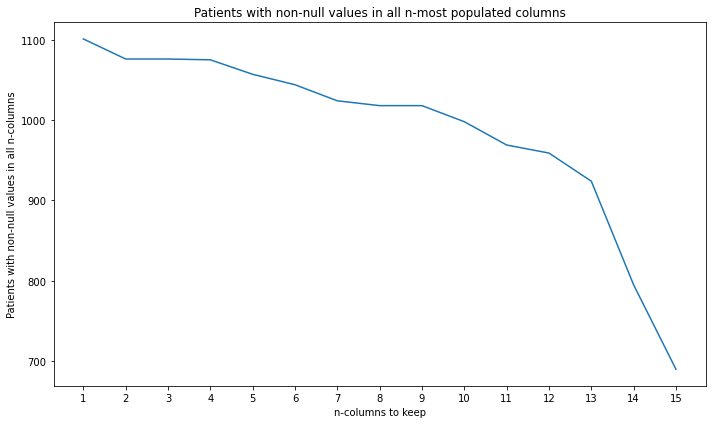

In [10]:
patientsKeptDF = pd.DataFrame(data=numPatientsKept)

patientsKeptDF['n_col'] =list(range(1, len(patientsKeptDF)+1))

patientsKeptDF = patientsKeptDF.set_index('n_col')



fig = plt.figure(figsize=(10, 6))

plt.xticks(patientsKeptDF.iloc[:,0].index)
plt.xlabel("n-columns to keep")
plt.ylabel("Patients with non-null values in all n-columns")
plt.title("Patients with non-null values in all n-most populated columns")
plt.plot(patientsKeptDF.iloc[:,0])
plt.tight_layout()
plt.show()

#### Sharp drop off after 12 columns so will keep around 1000 patients with at least some data in the top 12 columns

In [11]:
for patients in patientsKept:
    print(patients[0].clusteringColumns.columns)

Index(['Platelets'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin',
       'Arterial PaCO2'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systoli

In [12]:
clusteringPatients = patientsKept[11]
cols = clusteringPatients[0].clusteringColumns.columns

for patient in clusteringPatients:
    print(np.sum(patient.clusteringColumns.columns == cols))

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
1

In [13]:
print(clusteringPatients[1].clusteringColumns)

    Platelets  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
0         NaN                     46.0                   116.0   
1         NaN                     60.0                   129.0   
2         NaN                     54.0                   117.0   
3         NaN                     55.0                   125.0   
4         NaN                     43.0                    96.0   
5       107.0                     52.0                   116.0   
6         NaN                     49.0                   110.0   
7         NaN                     45.0                   107.0   
8         NaN                     43.0                   113.0   
9         NaN                     43.0                   104.0   
10        NaN                     42.0                   113.0   
11        NaN                     48.0                   135.0   
12        NaN                     50.0                   134.0   
13        NaN                     48.0                   133.0   
14       9

In [14]:
# columnsToInterpolate = ['Glucose']

noInterpolation = 0
failureExample = (0,0)

for idx, patient in tqdm(enumerate(clusteringPatients)):

    # print(patient.clusteringColumns)

    patient.interpolatedData = pd.DataFrame()

    patientNonNullCount = patient.clusteringColumns.count()

    for column in patient.clusteringColumns.columns:

        # print(patient.clusteringColumns[column])

        try:
            # print(patient.data.isnull().all())
            patient.interpolatedData[column] = patient.clusteringColumns[column].interpolate(method='polynomial', order=2, limit_direction='both', limit_area='inside')


            # print(patient.interpolatedData)
            
            # patient.interpolatedData[column] = patient.interpolatedData[column].interpolate(method='linear', limit_direction='both', fill_value='extrapolate')
    
        except ValueError:

            try:

                if patientNonNullCount[column] == 1:
                    patient.interpolatedData[column] = patient.clusteringColumns[column].interpolate(method='linear', limit_direction='both', limit=3)
                else: 
                    patient.interpolatedData[column] = patient.clusteringColumns[column].interpolate(method='linear', limit_direction='both', limit_area='inside')
            
            except ValueError:

                patient.interpolatedData[column] = patient.clusteringColumns[column].fillna(patient.clusteringColumns[column].mean())
                noInterpolation += 1
                failureExample = (idx, column)

        # print(patient.interpolatedData)

# Is this true?
print(f"{noInterpolation}/{len(patients)} patients have no missing values")
print(f"{failureExample}")

959it [00:11, 82.26it/s]

0/690 patients have no missing values
(0, 0)


In [15]:
display(clusteringPatients[958].interpolatedData['Platelets'])

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10    97.000000
11    96.260870
12    95.521739
13    94.782609
14    94.043478
15    93.304348
16    92.565217
17    91.826087
18    91.086957
19    90.347826
20    89.608696
21    88.869565
22    88.130435
23    87.391304
24    86.652174
25    85.913043
26    85.173913
27    84.434783
28    83.695652
29    82.956522
30    82.217391
31    81.478261
32    80.739130
33    80.000000
34          NaN
35          NaN
36          NaN
37          NaN
38          NaN
39          NaN
40          NaN
41          NaN
42          NaN
43          NaN
44          NaN
45          NaN
46          NaN
47          NaN
Name: Platelets, dtype: float64

In [16]:
def plotPatient(patient=1, feature='Platelets'):

    patient = clusteringPatients[patient]

    # fig = plt.figure(figsize = (30, 1.5))

    # plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)
    # plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
    # plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
    # plt.scatter(patient.clusteringColumns.index, patient.clusteringColumns[col])
    # plt.title(f"Patient: {patient}")

    ax = patient.interpolatedData[feature].plot()

    fig = ax.get_figure()

    plt.close(fig)

    return fig


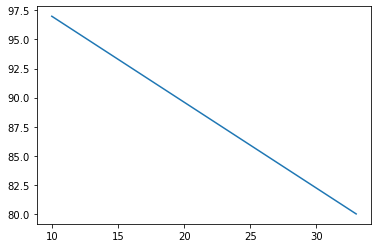

In [17]:
plotPatient(958, 'Platelets')

In [18]:
# import panel as pn

# pn.extension()

# pn.interact(plotPatient, patient=(1, len(clusteringPatients)), feature = list(clusteringPatients[0].interpolatedData.columns)).show()

Launching server at http://localhost:59031


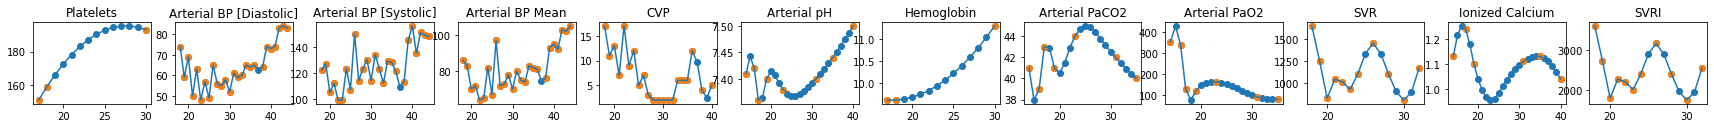

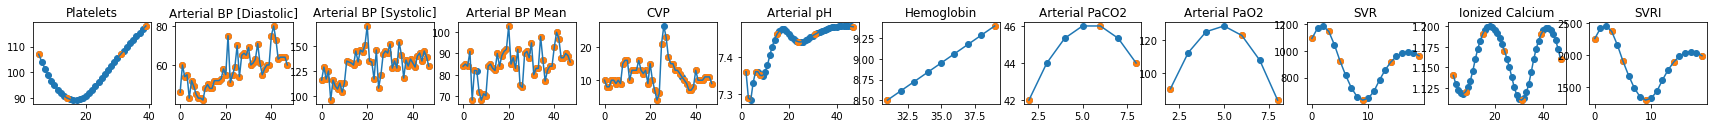

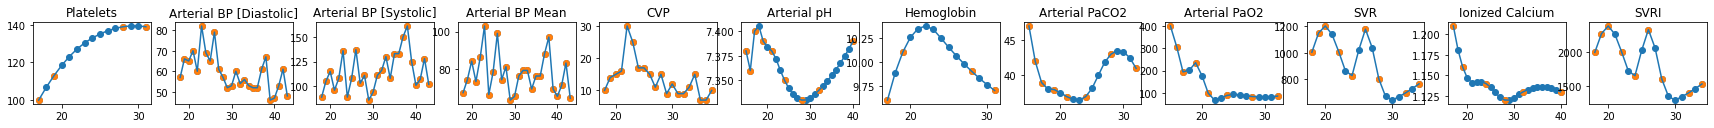

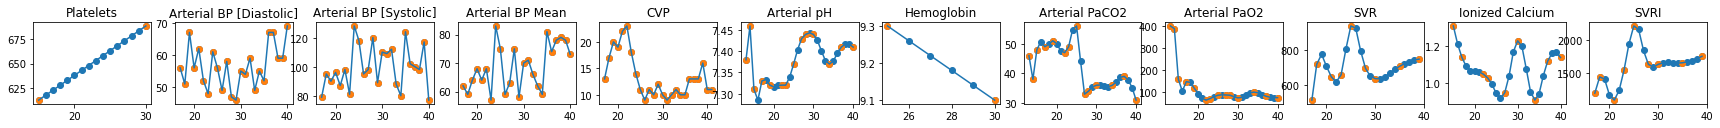

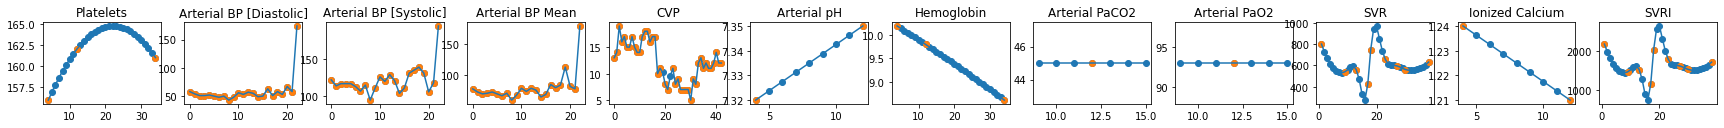

In [19]:

for i in range(len(clusteringPatients[:5])):

    # display(clusteringPatients[i].interpolatedData.head())

    fig = plt.figure(figsize = (30, 1.5))

    for idx, col in enumerate(clusteringPatients[i].interpolatedData.columns):
        plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)

        plt.plot(clusteringPatients[i].interpolatedData.index, clusteringPatients[i].interpolatedData[col])
        plt.scatter(clusteringPatients[i].interpolatedData.index, clusteringPatients[i].interpolatedData[col])
        plt.scatter(clusteringPatients[i].clusteringColumns.index, clusteringPatients[i].clusteringColumns[col])
        plt.title(f"{col}")

    plt.show()



In [20]:
# For time series clustering, the library needs the data to be formatted with all patient IDs in one dataframe.


# stackedDF = pd.DataFrame(columns=clusteringPatients[0].interpolatedData.columns)

# for patient in tqdm(clusteringPatients):
#     patient.interpolatedData['PatientID'] = patient.patientID
#     stackedDF = pd.concat((stackedDF, patient.interpolatedData))


# display(stackedDF)

# stackedNumpy = stackedDF.to_numpy()

# print(stackedNumpy)

# dataFormatted = to_time_series_dataset([*stackedNumpy])

# display(dataFormatted)

In [21]:
# dataDF = pd.DataFrame([patient.interpolatedData['Platelets'].values for patient in clusteringPatients])

# data = dataDF.to_numpy()

# dataFormatted = to_time_series_dataset([*data])

# # dataFormatted = TimeSeriesScalerMeanVariance().fit_transform(data)

# print(data)
# print(dataFormatted.shape)

In [71]:

def formatForTimeSeries(column):

    stackedDF = pd.DataFrame([patient.interpolatedData[column].values for patient in clusteringPatients])

    # print(stackedDF.shape)

    stackedNumpy = stackedDF.to_numpy()

    cleanedNumpy = []

    for row in stackedNumpy:
        cleanedNumpy.append(row[~np.isnan(row)])


    dataFormatted = to_time_series_dataset([*cleanedNumpy])

    return dataFormatted



def timeSeriesCluster(column, clusters):

    # print(f"Clustering {column}")

    dataFormatted = formatForTimeSeries(column)


    # Change hyper-parameters for better results?

    # max iter 200 takes approx 4 minutes
    model = TimeSeriesKMeans(n_clusters=clusters, tol=1e-3, metric="dtw", max_iter=2, random_state=0, n_jobs=4)
    y_pred = model.fit_predict(dataFormatted)

    # Calculating the score takes ages
    # print(silhouette_score(dataFormatted, y_pred))

    

    return dataFormatted, y_pred



# Has it's own silhouette_score
# print(silhouette_score(data, y_pred))


In [74]:
clusteredDF = pd.DataFrame(columns=clusteringPatients[0].interpolatedData.columns)

scores = {}

clusters = 5

# time_series_cluster('Platelets')

for column in tqdm(clusteredDF.columns):
    dataFormatted, y_pred = timeSeriesCluster(column, clusters)
    clusteredDF[column] = y_pred

    # Using sampling for the silhouette score since calculating the score on the entire dataset takes ages
    test_size = 0.1
    sample_idx = np.random.choice(dataFormatted.shape[0], int(test_size * len(dataFormatted)), replace=False)
    test_sample_x = dataFormatted[sample_idx]
    test_sample_y = [y_pred[i] for i in sample_idx]
    while len(np.unique(test_sample_y)) < 2:
        print("Recalculating sample due to too few clusters")
        sample_idx = np.random.choice(dataFormatted.shape[0], int(test_size * len(dataFormatted)), replace=False)
        test_sample_x = dataFormatted[sample_idx]
        test_sample_y = [y_pred[i] for i in sample_idx]
    # print(test_sample_x, test_sample_y)
    score = silhouette_score(test_sample_x, test_sample_y)
    scores[column] = score

print(f"{column}: {score}" for column, score in scores)



# display(clusteredDF)



  8%|▊         | 1/12 [00:21<04:01, 21.91s/it]

Platelets: 0.36468300807889226


 17%|█▋        | 2/12 [00:46<03:54, 23.44s/it]

Arterial BP [Diastolic]: 0.0815933571415167


 25%|██▌       | 3/12 [01:10<03:34, 23.83s/it]

Arterial BP [Systolic]: 0.12973804446342768


 33%|███▎      | 4/12 [01:37<03:19, 24.88s/it]

Arterial BP Mean: 0.16578997727714861


 42%|████▏     | 5/12 [02:03<02:57, 25.40s/it]

CVP: 0.1281721915150628


 50%|█████     | 6/12 [02:25<02:25, 24.31s/it]

Arterial pH: 0.1382937887494778


 58%|█████▊    | 7/12 [02:49<02:00, 24.04s/it]

Hemoglobin: 0.3303910067050765


 67%|██████▋   | 8/12 [03:18<01:43, 25.84s/it]

Arterial PaCO2: 0.14448220140831664


 75%|███████▌  | 9/12 [03:46<01:18, 26.24s/it]

Arterial PaO2: 0.15232080054898336


 83%|████████▎ | 10/12 [04:12<00:52, 26.43s/it]

SVR: 0.22997921726406148
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters


 92%|█████████▏| 11/12 [05:23<00:39, 39.94s/it]

Ionized Calcium: 0.9878403959414199


100%|██████████| 12/12 [05:51<00:00, 29.25s/it]

SVRI: 0.15561693783827021


In [90]:
print(scores)


{'Platelets': 0.36468300807889226, 'Arterial BP [Diastolic]': 0.0815933571415167, 'Arterial BP [Systolic]': 0.12973804446342768, 'Arterial BP Mean': 0.16578997727714861, 'CVP': 0.1281721915150628, 'Arterial pH': 0.1382937887494778, 'Hemoglobin': 0.3303910067050765, 'Arterial PaCO2': 0.14448220140831664, 'Arterial PaO2': 0.15232080054898336, 'SVR': 0.22997921726406148, 'Ionized Calcium': 0.9878403959414199, 'SVRI': 0.15561693783827021}


In [118]:
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [177]:
def removeOutliers(data, threshold):
    stdDev = np.nanstd(data)
    # print(stdDev)
    mean = np.nanmean(data)
    # print(mean)
    normalised = [np.nanmean(np.abs(d - mean)) for d in data]
    mask = normalised < threshold * stdDev
    return data[mask], data[np.logical_not(mask)]

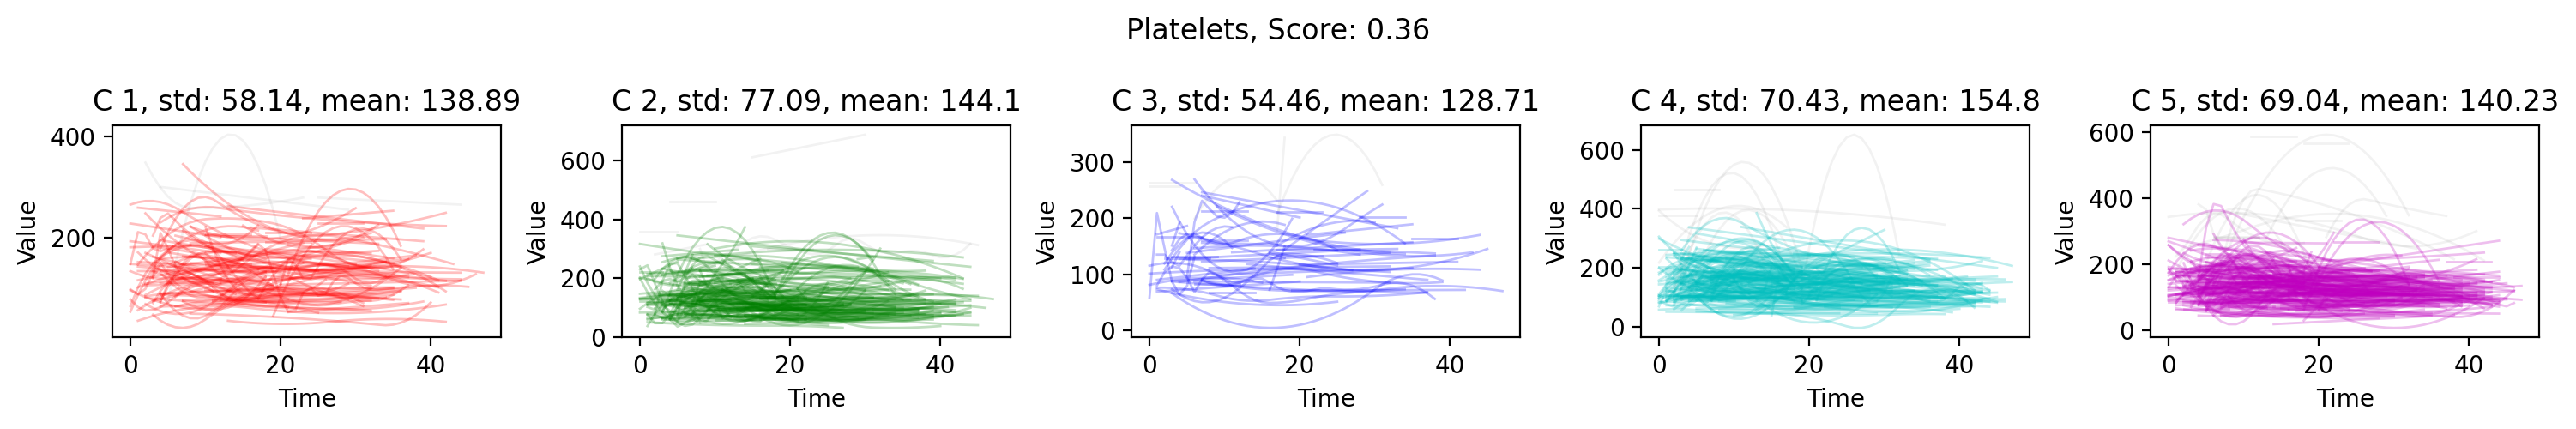

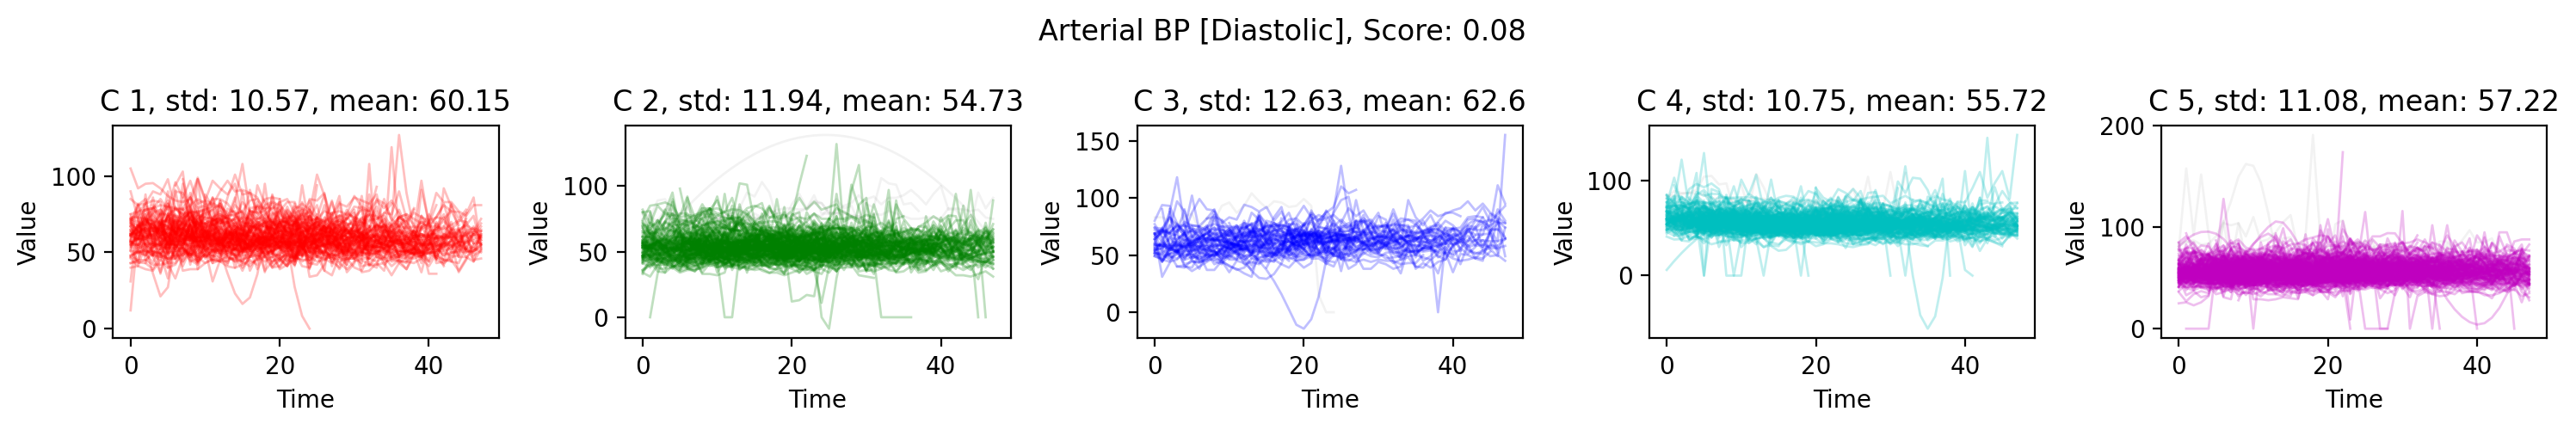

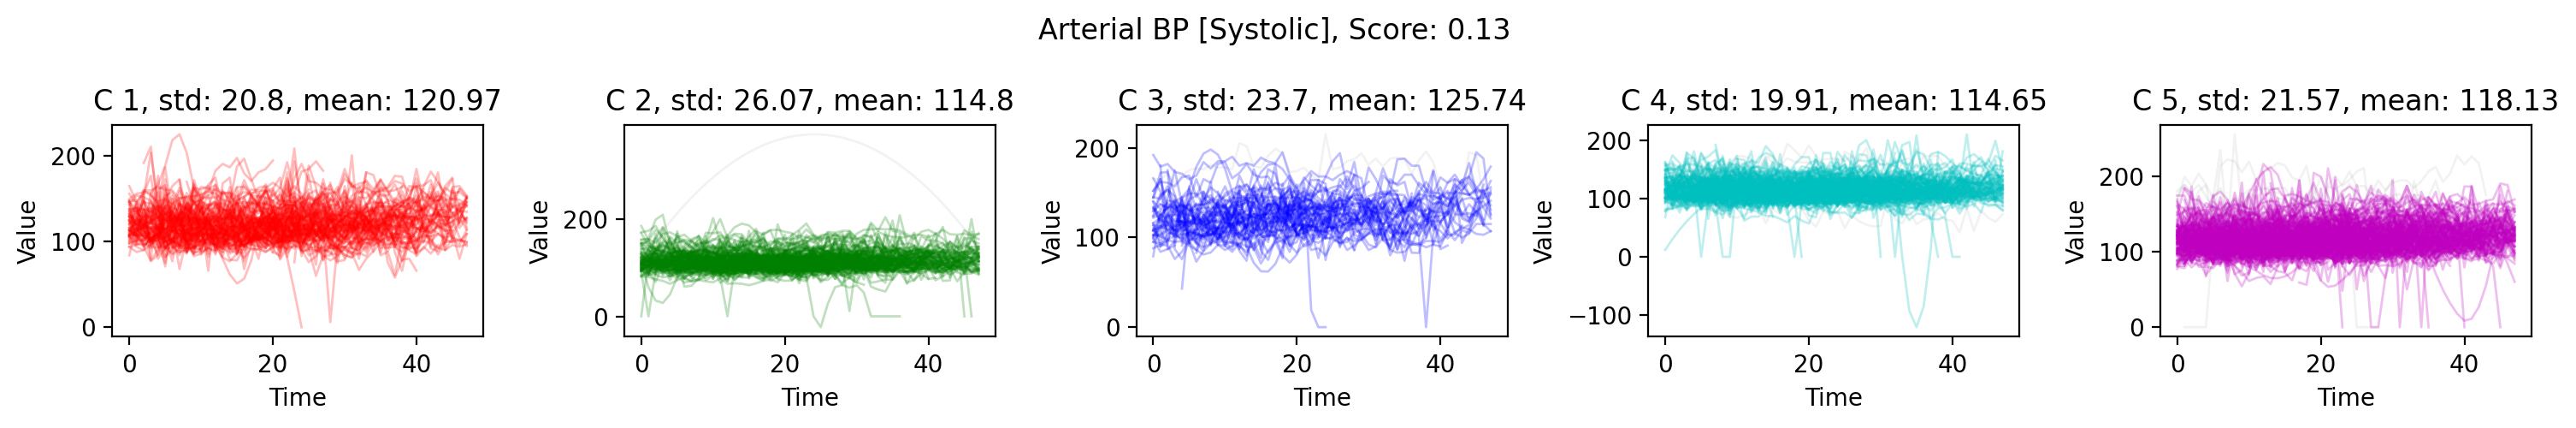

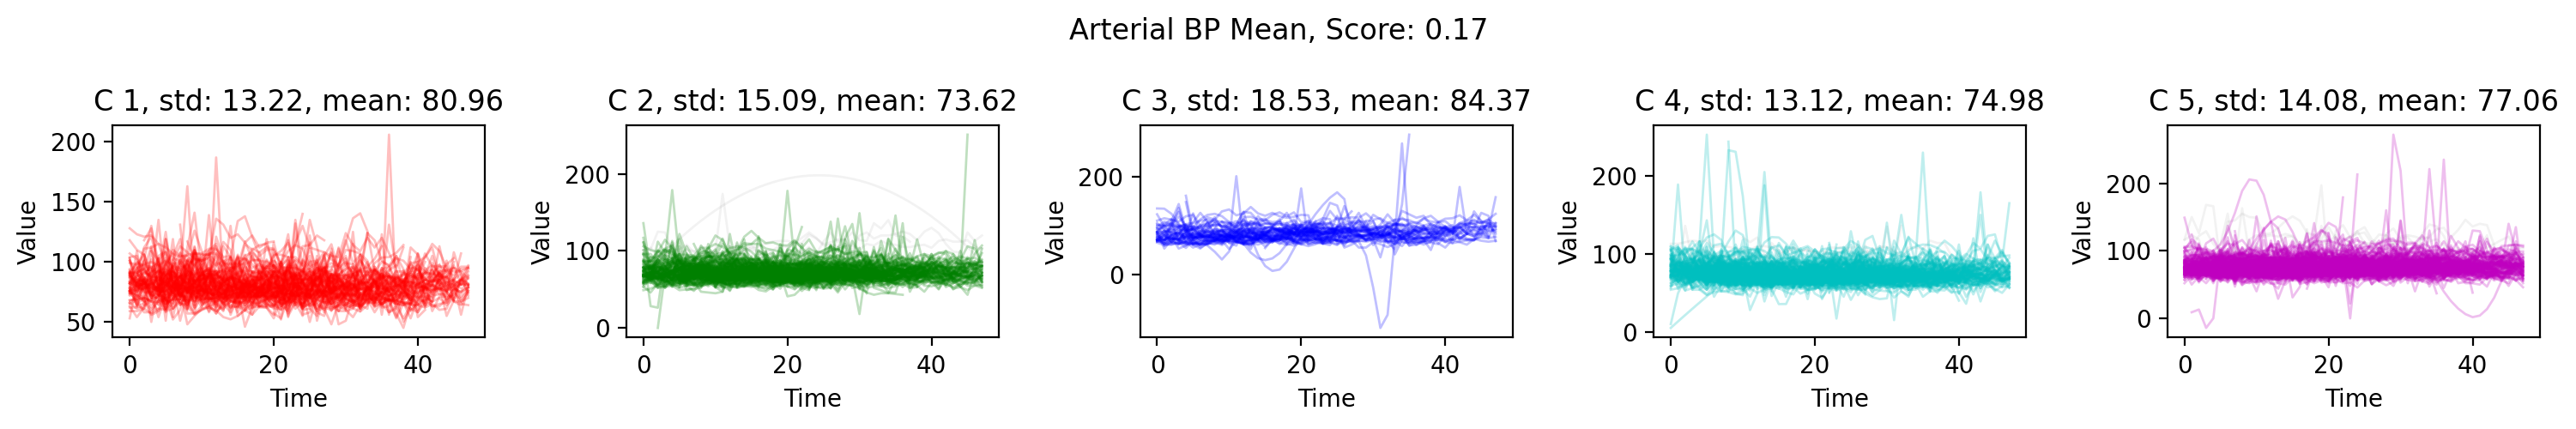

In [181]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}


for col in clusteredDF.columns:


    fig = plt.figure(figsize=(clusters*3,2.5), dpi=200)

    fig.suptitle(f"{col}, Score: {np.round(scores[col], 2)}")

    colData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]
    # print(colData)

    for i in range(clusters):
        plt.subplot(1, clusters, i+1)

        dataCluster = np.array(colData)[y_pred == i]

        withoutOutliers, outliers = removeOutliers(dataCluster, 2)
        
        # print(f"Num removed: {len(dataCluster) - len(withoutOutliers)}")

        # print(len(dataCluster))
        # print(len(withoutOutliers))
        
        for sample in outliers:
            plt.plot(sample, c='black', alpha=0.05, linewidth=1)
        
        for sample in withoutOutliers:
            plt.plot(sample, c=colours[i], alpha=0.25, linewidth=1)

        plt.title(f"C {i+1}, std: {np.round(np.nanstd(dataCluster), 2)}, mean: {np.round(np.nanmean(dataCluster), 2)}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        # print(dataCluster)
        # print(np.nanstd(dataCluster))

        
    plt.tight_layout()
    plt.show()

